# Intro

This kernel shows how to get started on segmentating nuclei using a neural network in Keras.  
  
The architecture used is the so-called **U-Net**, which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras import backend as K

import tensorflow as tf

# set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './data-science-bowl-2018/stage1_train/'
TEST_PATH = './data-science-bowl-2018/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
# get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [46]:
train_ids

['5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856',
 '68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254722728a8b7d596fd4c',
 '6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56',
 'e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b',
 'a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4',
 '3441821ebea04face181c9e2f4d0d09727c764827ac51b9e7fbadbebabeab225',
 'a0afead3b4fe393f6a6159de040ecb2e66f8a89090abf0d0bf5b8e1d38ae667c',
 '98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0',
 'd3ce382f190ee24729bd2e80684c11bef72bc9c733cdbbc19a17d2c1b2e775f7',
 'c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a',
 'e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243',
 '4ff152d76db095f75c664dd48e41e8c9953fd0e784535883916383165e28a08e',
 'fadeb0ab092833f27daaeb3e24223eb090f9536b83f68cde8f49df7c544f711b',
 '1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5',
 '2d53d7ec0c579fffd6710c956288537d

# Get the data

Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now.  
  
- resize의 mode='constant': 입력의 경계를 벗어난 포인트는 주어진 모드에 따라 채워진다.
- resize의 preserve_range: 원래 값 범위를 유지할지 여부  
*이미지 보정에 대해서 더 공부할 것*

In [5]:
# get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ...')

sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

# get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ...


/var/folders/ny/473vxrss0zd4s69y33w2wprr0000gn/T/ipykernel_36467/1441734842.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|          | 0/670 [00:00<?, ?it/s]/var/folders/ny/473vxrss0zd4s69y33w2wprr0000gn/T/ipykernel_36467/1441734842.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-no

Getting and resizing test images ...



100%|██████████| 65/65 [00:01<00:00, 36.55it/s]

Done!


In [18]:
# imshow에서 boolean type 지원 X
Y_train = Y_train.astype(float)

Let's see if things look all right by drawing some random images and their associated masks.

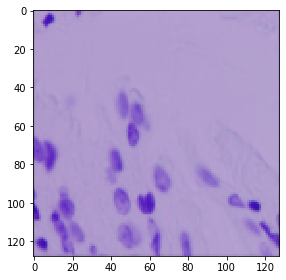

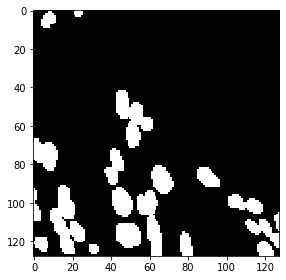

In [19]:
# check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

# Create our Keras metric

Now we try to define the *mean average precision at different intersection over union (IoU) thresholds* metric in Keras.  
Tensorflow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. I'm by no means certain that this implementation is correct, though.  
  
Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train...
  
### IoU(Intersection over Union)
실측값(Ground Truth)과 모델이 예측한 값이 얼마나 겹치는지 나타내는 지표  
![iou](./iou_equation.png)    
![iou_example](./iou_examples.png)

In [20]:
# 텐서플로 2. 에서는 지원되지 않는 메소드들이 많음
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

In [21]:
def IoU(y_pred, y_true):
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)

# Build and train our neural network

<img src="./u-net-architecture.png" width="60%" height="50%"></img>  
  
1. 초반 부분: 수축 경로
    - Max pooling 사용하여 해상도(너비와 높이) 2배 감소
    - Conv 연산으로 채널 크기는 2배 증가
    - Conv + ReLU + Max pooling
    - 넓은 문맥(context) 정보를 처리한다.
      
2. 후반 부분: 확장 경로
    - Conv2DTranspose로 해상도 2배 증가
    - Conv 필터를 줄여서 채널 크기는 2배 감소
    - 수축 경로에서 처리된 피처를 연결  
    - 정밀한 지역화(precise localization)를 처리한다.
  
- Conv2DTranspose  
![conv2dtranspose](./conv2dtranspose.gif)

- elu  
<img src='./elu.png' width=50% height=40%></img>
- kernel_initializer: 가중치 초기화방식 설정
    - he_normal: He 정규분포 초기값으로 설정 (Kaiming He 가 2015년에 제안한 최신의 초기화 방식으로 경험적으로 좀 더 좋은 결과는 낸다고 알려져 있다.)
        
  
- concatenate: 레이어 합침

In [22]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[IoU])
model.summary()


2022-09-18 19:24:26.000492: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [27]:
# fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.1444 - IoU: 0.6470
Epoch 1: val_loss improved from inf to 0.13100, saving model to model-dsbowl2018.h5
38/38 [==============================] - 37s 978ms/step - loss: 0.1444 - IoU: 0.6470 - val_loss: 0.1310 - val_IoU: 0.6441
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.1343 - IoU: 0.6621
Epoch 2: val_loss improved from 0.13100 to 0.11730, saving model to model-dsbowl2018.h5
38/38 [==============================] - 37s 962ms/step - loss: 0.1343 - IoU: 0.6621 - val_loss: 0.1173 - val_IoU: 0.6768
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.1170 - IoU: 0.7002
Epoch 3: val_loss improved from 0.11730 to 0.10304, saving model to model-dsbowl2018.h5
38/38 [==============================] - 38s 997ms/step - loss: 0.1170 - IoU: 0.7002 - val_loss: 0.1030 - val_IoU: 0.7053
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.1092 - IoU: 0.7158
Epoch 4: val_loss 

# Make predictions

Let's make predictions both on the test set, the val set and train set (as a sanity check).  
Remember to load the best saved model if you've used early stopping and checkpointing.

In [28]:
# predict on train, val and test
model = load_model('model-dsbowl2018.h5', custom_objects={'IoU':IoU})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 1s 197ms/step


In [29]:
# threshold predictions
# 임계값이 0.5 이상인 결과만 가져오기
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [30]:
# create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

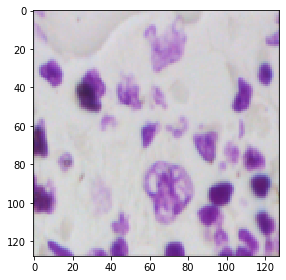

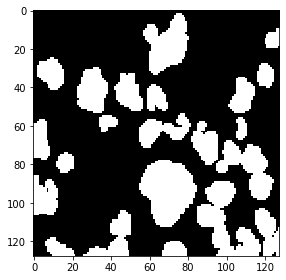

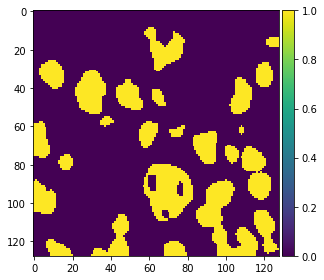

In [31]:
# perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

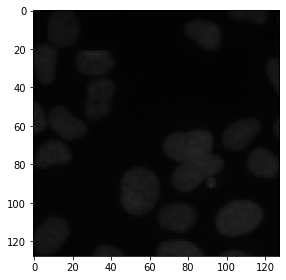

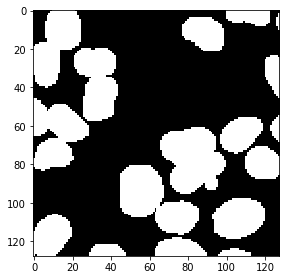

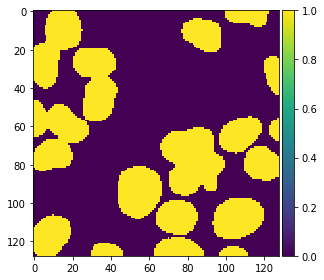

In [32]:
# perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

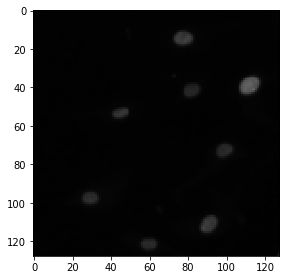

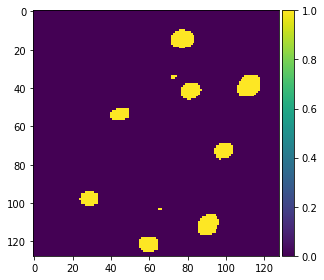

In [45]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
# imshow(np.squeeze(Y_train[ix]))
# plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

# Encode and submit our results

In [33]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    
    for b in dots:
        if (b > prev+1):
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    
    return run_lengths

In [34]:
def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)

    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [35]:
new_test_ids = []
rles = []

for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [36]:
# create submission DataFrame
# 제출 형식과 다름
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018.csv', index=False)